# this is a second part of the satellite image processing.
here we are using tensorflow platform for training a UNET model to segment buildings in an image. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rand
import skimage.io
import matplotlib.pyplot as plt
from skimage import transform
import os, glob
import shutil
from tqdm import tqdm
import tensorflow as tf
from skimage.io import imread, imshow
from subprocess import check_output

In [2]:
train_path = 'data/images-256'
train_images = [f for f in glob.glob(train_path + "*/*.png", recursive=True)]
print(len(train_images))

ground_t_path = 'data/masks-256'
train_masks= [f for f in glob.glob(ground_t_path + "*/*.png", recursive=True)]
print(len(train_masks))

1261
1261


In [3]:
#DIMENSIONS FOR IMAGES TO TRAIN AND TEST
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3 

X_train = np.zeros((len(train_images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8) 
Y_train= np.zeros((len(train_masks), IMG_HEIGHT, IMG_WIDTH,1), dtype = np.bool)

In [4]:
#converting images to(128*128 )  
import cv2 as cv
for i in range(len(train_images)):
    img=cv.imread(train_images[i])
    X_train[i]=cv.resize(img,  (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
X_train.shape
#RESHAPING  MASKS to (128*128)
for i in range(len(train_masks)):
    img = cv.imread(train_masks[i])
    fin_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    resized = cv.resize(fin_img,  (IMG_WIDTH, IMG_WIDTH), interpolation = cv.INTER_AREA)
    Y_train[i]=np.expand_dims(resized,axis=-1)


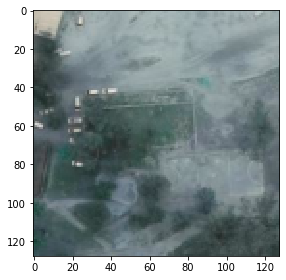

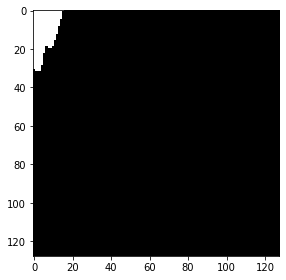

In [5]:
import random
image_x = random.randint(4, len(train_images))
imshow(np.squeeze(X_train[image_x]))
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [7]:
# Flipping images with Numpy
image = []
masks = []
temp_mask=np.zeros(shape=(0,128,128,1))
# noise = np.random.randint(5, size = (128, 128, 4), dtype = 'uint8')
for r in range(400):
    l = rand.randint(1,99)
    img=X_train[l]
    mask=Y_train[l]
    flipped_img=np.fliplr(img)
    flipped_mask=np.fliplr(mask)
    image.append(flipped_img)
#     masks.append(masks)
    interm_arr=np.asarray(flipped_mask)
    interm_arr=np.expand_dims(interm_arr,axis=0)
    temp_mask=np.append(temp_mask, interm_arr, axis=0)


In [8]:
images_arr=np.asarray(image)
X_train=np.append(X_train, images_arr, axis=0)
X_train.shape

(1661, 128, 128, 3)

In [9]:
Y_train=np.append(Y_train,temp_mask, axis=0)
Y_train.shape

(1661, 128, 128, 1)

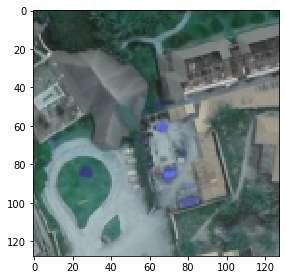

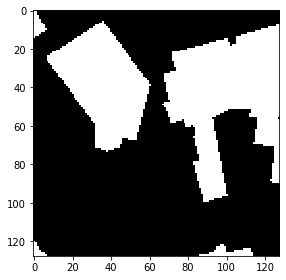

In [10]:
imshow(np.squeeze(X_train[16]))
plt.show()
imshow(np.squeeze(Y_train[16]))
plt.show()

In [11]:
#from https://github.com/fear-the-lord/Image-Segmentation/blob/master/Image_Segmentation.ipynb
#Build the model(EXPANSION PATH)

# Step 1: Defining the input layer 
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
# Step 2: Convert the integer values of the input to floating points 
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#LAYER 1
# Step 3: Forming the first conv layer 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(s)
# Step 4: Add dropout 
c1 = tf.keras.layers.Dropout(rate = 0.1)(c1)
# Step 5: Forming the second conv layer
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
# Step 6: Forming the max pool layer 
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

#LAYER 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(rate = 0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

#LAYER 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(rate = 0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

#LAYER 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(rate = 0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

#LAYER 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(rate = 0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)

In [12]:
#Build the Model(CONTRACTION PATH)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(rate = 0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(rate = 0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(rate = 0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(rate = 0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)

In [13]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

model1 = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [75]:
# Adding a model checkpoint 

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_new.h5', verbose = 2, save_best_only = True)

callback = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss'),
            tf.keras.callbacks.TensorBoard(histogram_freq = 0)]

results = model1.fit(X_train, Y_train, validation_split = 0.20, batch_size = 15, epochs = 16, callbacks = callback)

Train on 1328 samples, validate on 333 samples
Epoch 1/16
1328/1328 [==============================] - 182s 137ms/sample - loss: 0.0870 - accuracy: 0.9655 - val_loss: 0.1431 - val_accuracy: 0.9409
Epoch 2/16
1328/1328 [==============================] - 190s 143ms/sample - loss: 0.0858 - accuracy: 0.9658 - val_loss: 0.1280 - val_accuracy: 0.9463
Epoch 3/16
1328/1328 [==============================] - 181s 136ms/sample - loss: 0.0839 - accuracy: 0.9664 - val_loss: 0.1288 - val_accuracy: 0.9470
Epoch 4/16
1328/1328 [==============================] - 181s 136ms/sample - loss: 0.0873 - accuracy: 0.9654 - val_loss: 0.1227 - val_accuracy: 0.9490
Epoch 5/16
1328/1328 [==============================] - 181s 136ms/sample - loss: 0.0763 - accuracy: 0.9693 - val_loss: 0.1229 - val_accuracy: 0.9488
Epoch 6/16
1328/1328 [==============================] - 181s 136ms/sample - loss: 0.0733 - accuracy: 0.9704 - val_loss: 0.1370 - val_accuracy: 0.9421
Epoch 7/16
1328/1328 [==============================]

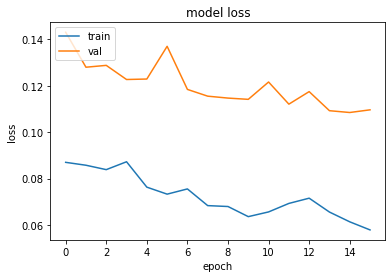

In [76]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [77]:
predict_train = model1.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose = 1)
predict_val = model1.predict(X_train[int(X_train.shape[0] * 0.9):], verbose = 1)
# pred_test = model1.predict(X_test, verbose = 1)

167/167 [==============================] - 4s 26ms/sample


In [78]:
predict_train_t = (predict_train > 0.50).astype(np.uint8)
predict_val_t = (predict_val > 0.50).astype(np.uint8)
pred_test_t = (predict_val > 0.50).astype(np.uint8)

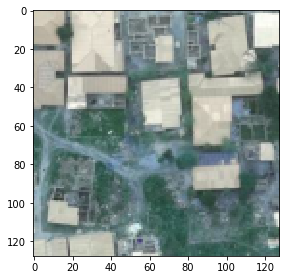

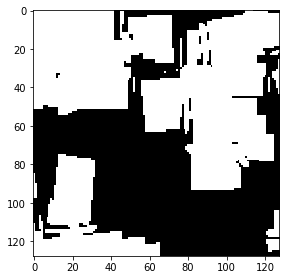

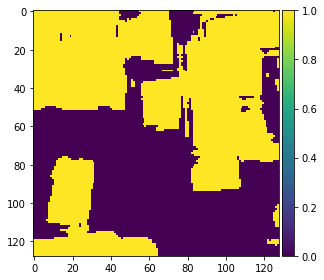

0.8871993960961932


In [96]:
 #Perform a sanity check on some random training samples 
ix = random.randint(0, len(predict_val_t))
# ix=616
imshow(X_train[ix])

plt.show()
imshow(np.squeeze(Y_train[ix]))

plt.show()
imshow(np.squeeze(predict_train_t[ix]))

plt.show()
#IOU CHECKING FOR MODEL EVALUATION

component1 = np.float32(Y_train[ix])
component2 = predict_train_t[ix]
overlap = np.logical_and(component1, component2) # Logical AND
union = np.logical_or(component1, component2) # Logical OR

IOU = overlap.sum()/float(union.sum())
print(IOU)